In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

A fundamental object with NNs is the "layer". We can define custom layers for all kinds of uses. One of the simplest things we can do is use a layer to enforce a Dirichlet boundary condition. This highlights the main aspects of constructing a custom layer. 

In [2]:

##Custom layers are classes
class  bc_layer(tf.keras.layers.Layer):
    
    ##After self, we can put any inputs we like. I'll put the a,b where we want to enforce the Dirichlet condition
    def __init__(self,a,b):
        super(bc_layer,self).__init__()
        ##Any initialisation 
        
        self.a =a
        self.b =b
    
    #call tells you how to go from the input of the layer to the output
    #This layer will have two inputs, the output of the penultimate layer and the x-value, 
    #Needed to employ the cutoff
    def call(self,inputs):
        ut,x = inputs
        
        #By default, the output is shape [N,1]. It'll be more convenient if it's just 
        #[N], as this means we have a truely scalar output, making arithmetic easier. 
        #tf.reshape(x,[-1]) essentially "flattens" a tensor
        x=tf.reshape(x,[-1])
        
        #Einsum is like einstein summation, takes [N,1] and [N] to [N]
        return tf.einsum("Ij,I->I",ut,(x-self.a)*(self.b-x))

One the layer is defined, it can be used just like any other layer. Let's make a simple NN with it. 

In [3]:
xvals = tf.keras.layers.Input(shape=(1,))

l1 = tf.keras.layers.Dense(50,activation=tf.math.tanh)(xvals)

l2 = tf.keras.layers.Dense(50,activation=tf.math.tanh)(l1)

l3 = tf.keras.layers.Dense(1)(l2)

u_out = bc_layer(-1,1)([l3,xvals])

u_model = tf.keras.Model(inputs = xvals, outputs = u_out)
print(u_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 50)                │             100 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 50)                │           2,550 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              51 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bc_layer (bc_layer)           │ (None)                    │               0 │ dense_2[0][0],             │
│                               │                           │                 │ input_layer[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

None


We can check that it cuts off correctly

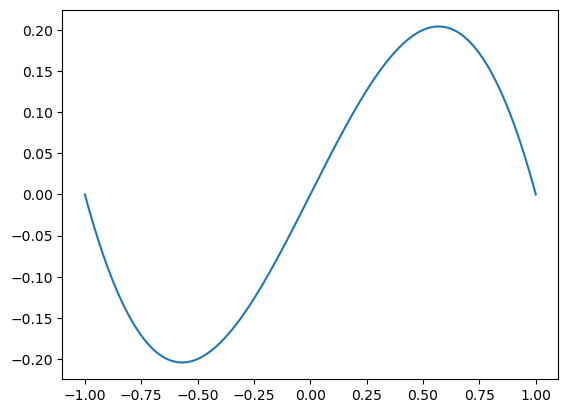

In [4]:
xplot = tf.constant([i/100-1 for i in range(201)])
uplot = u_model(xplot)
plt.plot(xplot,uplot)
plt.show()

Custom layers can be used to introduce all kinds of functionality into your architecture. If we want to use the "native" tensorflow functionality to train a PINN, we can also use layers to define the loss itself! The native functionality doesn't allow us to define loss functions based on derivatives, but we can work around this using a second "neural network" which outputs the loss. First, we define a custom layer with "dummy" input and outputs the loss. Let's do this. 

In [5]:
class loss_layer(tf.keras.layers.Layer):
    
    #We define our solution NN to be an object inside the layer
    def __init__(self,u_model):
        super(loss_layer,self).__init__()
        ##Any initialisation 
        
        self.u_model = u_model
    
    #We then just evaluate the loss we want inside the call function
    def call(self,inputs):
        
        #We take an MC sample of points 
        x = tf.random.uniform([500],minval=-1)
        
        #Evaluate the second derivative
        with tf.GradientTape() as t1:
            t1.watch(x)
            with tf.GradientTape() as t2:
                t2.watch(x)
                u = self.u_model(x)
            du = t2.gradient(u,x)
        ddu = t1.gradient(du,x)
        
        #And evaluate the residual
        residual = ddu -x**2
        
        return tf.reduce_mean(residual**2)**0.5

We can make a new model to output the loss

In [6]:
xvals = tf.keras.layers.Input(shape=(1,))

loss_out = loss_layer(u_model)(xvals)

loss_model = tf.keras.Model(inputs = xvals, outputs = loss_out)
print(loss_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ loss_layer (loss_layer)              │ ()                          │           2,701 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
loss_model(tf.constant([1.]))

<tf.Tensor: shape=(), dtype=float32, numpy=1.7536710500717163>

Even though the model output is our loss, to use the model.fit capabilities, we need a "loss" function in the language of tensorflow. We define a custom loss function (from tensorflow's perspective) which simply returns the output of the loss_model

In [8]:
def dummy_loss(y_true,y_pred):
    return y_pred

With this, we can basically use tensorflow's functionality "as is", by putting the loss inside a highly flexible layer. From here, there is little difference with the interpolation problem we saw before. The loss model has a "dummy" input, so we just put the x/y data as a simple tensor

In [9]:
##Define the optimiser
opt = tf.keras.optimizers.Adam(learning_rate=10**-3)
loss_model.compile(loss=dummy_loss,optimizer=opt)
history = loss_model.fit(x=tf.constant([1.]),
                        y=tf.constant([1.]),
                        epochs=250)

Epoch 1/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.8497
Epoch 2/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 1.4798
Epoch 3/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 1.2064
Epoch 4/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.8425
Epoch 5/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.5346
Epoch 6/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.3744
Epoch 7/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.3967
Epoch 8/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.5261
Epoch 9/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.6042
Epoch 10/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.6642
Epoch 11/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.6508
Epoch 12/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.5837
Epoch 13/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.5047
Epoch 14/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.4200
Epoch 15/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3547
Epoch 16

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0981
Epoch 83/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0992
Epoch 84/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0867
Epoch 85/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0857
Epoch 86/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0731
Epoch 87/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0695
Epoch 88/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0630
Epoch 89/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0601
Epoch 90/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0533
Epoch 91/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0484
Epoch 92/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0468
Epoch 93/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0431
Epoch 94/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0438
Epoch 95/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0390
Epoch 96/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0421
Epoch 97

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0395
Epoch 163/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0354
Epoch 164/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0352
Epoch 165/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0354
Epoch 166/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0338
Epoch 167/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0359
Epoch 168/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0323
Epoch 169/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0349
Epoch 170/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0370
Epoch 171/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0324
Epoch 172/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0331
Epoch 173/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0349
Epoch 174/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0337
Epoch 175/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0348
Epoch 176/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0329
Ep

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0326
Epoch 243/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0314
Epoch 244/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0291
Epoch 245/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0315
Epoch 246/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0329
Epoch 247/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0286
Epoch 248/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0297
Epoch 249/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0297
Epoch 250/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0313


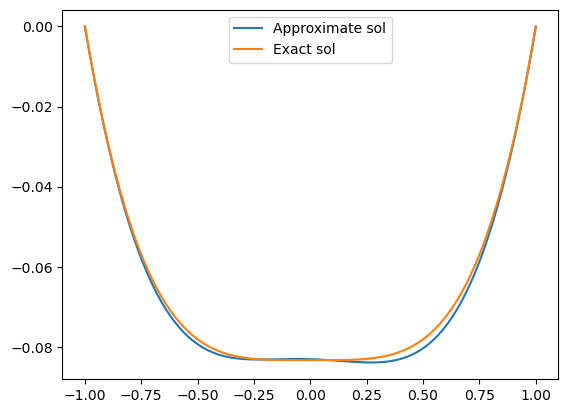

In [10]:
plt.plot(xplot,u_model(xplot),label="Approximate sol")
plt.plot(xplot,xplot**4/12-1/12,label="Exact sol")
plt.legend()
plt.show()

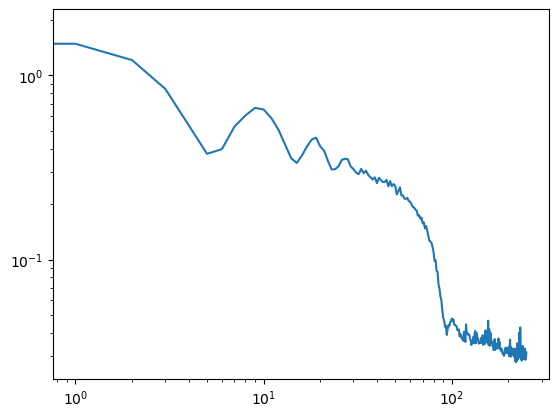

In [11]:
plt.plot(history.history["loss"])
plt.xscale("log")
plt.yscale("log")
plt.show()

This approach is useful for more "straightforward" losses, optimisation schemes, etc., and allows use of a lot of native tensorflow machinery (callbacks, etc.). 